## 最为整体

## 区分亚组

In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet3')

# 删除 'Group' 列中等于 3 的行
data = data[data['Cluster'] != 3]

# 将列名中的空格替换为下划线，去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ("reaction_times_in_incongruent_stimuli_at_baseline", "reaction_times_in_incongruent_stimuli_at_follow-up"),
    ("stroop_interference_effect_at_baseline", "stroop_interference_effect_at_follow-up"),
    ("accuracy_in_Nogo_trials_at_baseline", "accuracy_in_Nogo_trials_at_follow-up"),
    ("Switching_cost_at_baseline", "Switching_cost_at_follow-up"),
    ("accuracy_in_1750_ms_at_baseline", "accuracy_in_1750_ms_at_follow-up"),
    ("accuracy_in_750_ms_at_baseline", "accuracy_in_750_ms_at_follow-up"),
    ("span_in_digit_span_backward_task_at_baseline", "span_in_digit_span_backward_task_at_follow-up")
]

# 添加主题列
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所有列名一致
required_columns = [
    'Cluster', 'Subject', 'Age',
    'Education_years', 'Gender'
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(baseline_var, followup_var):
    # 确保变量名一致
    baseline_var = baseline_var.replace(' ', '_')
    followup_var = followup_var.replace(' ', '_')

    # 数据重塑为长格式
    df_long = pd.melt(data, id_vars=required_columns, 
                      value_vars=[baseline_var, followup_var], 
                      var_name='Time', value_name='Score')
    
    df_long['Time'] = df_long['Time'].map({baseline_var: 0, followup_var: 1})
    df_long['Cluster'] = df_long['Cluster'].astype('category')
    
    # 哑变量生成
    df_long = pd.get_dummies(df_long, columns=[
        'Gender'], drop_first=True)

    # 定义线性混合效应模型公式
    formula = ("Score ~ Time * Cluster + Age + "
               "Education_years + " +
               " + ".join(df_long.columns[df_long.columns.str.startswith(('Gender_'))]))
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的p值
    p_values = mdf.pvalues.loc[['Time', 'Cluster[T.1]', 'Time:Cluster[T.1]']]

    # 多重比较校正
    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    p_values_corrected_dict = dict(zip(p_values.index, p_values_corrected))

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'Time_pvalue': p_values.loc['Time'],
        'Cluster_pvalue': p_values.loc['Cluster[T.1]'],
        'Interaction_pvalue': p_values.loc['Time:Cluster[T.1]'],
        'Time_pvalue_corrected': p_values_corrected_dict['Time'],
        'Cluster_pvalue_corrected': p_values_corrected_dict['Cluster[T.1]'],
        'Interaction_pvalue_corrected': p_values_corrected_dict['Time:Cluster[T.1]'],
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for baseline_var, followup_var in variables:
    results[baseline_var] = perform_lmm_analysis(baseline_var, followup_var)

# 定义绘图函数
def plot_interaction(df_long, var_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette="muted")

    plt.title(f'Interaction Plot for {var_name}')
    plt.xlabel('Time')
    plt.ylabel('Score')
    plt.xticks([0, 1], ['Baseline', 'Follow-up'])
    plt.legend(title='Cluster', loc='upper left')
    plt.tight_layout()
    plt.show()

# 输出结果
for var, result in results.items():
    print(f"Variable: {var}")
    print(result['LMM_summary'])
    print(f"Time p-value (corrected): {result['Time_pvalue_corrected']:.3f}")
    print(f"Cluster p-value (corrected): {result['Cluster_pvalue_corrected']:.3f}")
    print(f"Interaction p-value (corrected): {result['Interaction_pvalue_corrected']:.3f}")

    # 进行事后比较
    if result['Interaction_pvalue_corrected'] < 0.05:  # Check for significance
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Cluster'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)

        # 修改Tukey HSD表的显示
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        summary_df['group1'] = summary_df['group1'].replace({'0_0': 'baseline_Subtype I', '0_1': 'baseline_Subtype II', 
                                                             '1_0': 'followup_Subtype I', '1_1': 'followup_Subtype II'})
        summary_df['group2'] = summary_df['group2'].replace({'0_0': 'baseline_Subtype I', '0_1': 'baseline_Subtype II', 
                                                             '1_0': 'followup_Subtype I', '1_1': 'followup_Subtype II'})
        print(tabulate(summary_df, headers='keys', tablefmt='pretty'))

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Cluster'])['Score'].agg(['mean', 'std']).reset_index()
        means['Cluster'] = means['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
        means['Time'] = means['Time'].map({0: 'baseline', 1: 'followup'})
        
        for idx, row in means.iterrows():
            print(f"Cluster: {row['Cluster']}, Time: {row['Time']}, Mean: {row['mean']:.2f}, Std: {row['std']:.2f}")
    print("---")

Variable: reaction_times_in_incongruent_stimuli_at_baseline
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Score     
No. Observations:    172        Method:                REML      
No. Groups:          86         Scale:                 8574.6490 
Min. group size:     2          Log-Likelihood:        -1059.8124
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           654.133   69.611  9.397 0.000 517.698 790.568
Cluster[T.1]         40.876   34.836  1.173 0.241 -27.401 109.153
Time                -28.222   25.270 -1.117 0.264 -77.750  21.307
Time:Cluster[T.1]   -24.206   32.190 -0.752 0.452 -87.297  38.885
Age                   1.496   

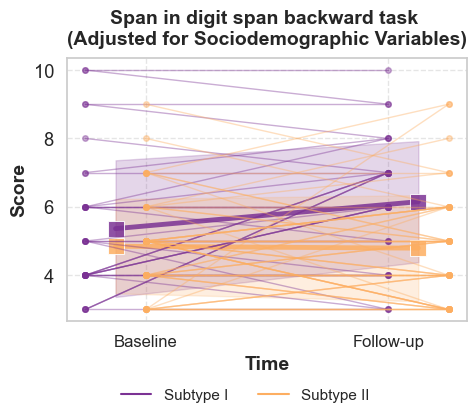

In [16]:
def plot_interaction(df_long, var_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # 设置整体风格，确保图表清晰且专业，增强图表对比度
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(5, 4.6))  # 提高分辨率以满足高水平出版要求
    
    # 将群组标签映射到新的名称
    df_long['Cluster'] = df_long['Cluster'].map({0: 'Subtype I', 1: 'Subtype II'})
    

    palette = {"Subtype I": "#7b3294", "Subtype II": "#fdae61"}
    # 绘制带误差条的交互作用图，并调整透明度以突出关键趋势线
    sns.lineplot(x="Time", y="Score", hue="Cluster", 
                 data=df_long, markers=True, dashes=False, 
                 ci='sd', palette=palette, 
                 marker='s', linewidth=3.5, alpha=0.85, markersize=12)
    
    # 为每个亚组设置不同的颜色，并在X轴上错开显示
    offset = {'Subtype I': -0.1, 'Subtype II': 0.1}  # 设置X轴偏移量
    for cluster, color in zip(['Subtype I', 'Subtype II'], ["#7b3294", "#fdae61"]):
        grp = df_long[df_long['Cluster'] == cluster]
        for _, subject_grp in grp.groupby('Subject'):
            x_positions = subject_grp['Time'] + offset[cluster]  # 添加偏移量
            plt.plot(x_positions, subject_grp['Score'], marker='o', color=color, alpha=0.4, linewidth=1.0, markersize=4)

    # 图表标题和标签，使用更加清晰的字体大小和粗细
    plt.title(f'Span in digit span backward task \n(Adjusted for Sociodemographic Variables)', fontsize=14, fontweight='bold', pad=10)
    plt.xlabel('Time', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.xticks([0.1, 0.9], ['Baseline', 'Follow-up'], fontsize=12)
    
    # 调整图例的位置和标签，设置图例框架和位置
    plt.legend(loc='upper left', fontsize=11, frameon=False, ncol=2, bbox_to_anchor=(0.1,-0.2))
    
    # 设置网格线，提升图表的专业感，适度降低透明度
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()  # 自动调整布局，确保图表元素不重叠
    plt.savefig(f'image/{var_name}.jpg', dpi=1200, bbox_inches='tight')
    plt.show()

# 调用示例：绘制指定变量的交互作用图
var_name = 'span_in_digit_span_backward_task_at_baseline'
plot_interaction(results[var_name]['df_long'], var_name)

In [17]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.filterwarnings('ignore')
# 读取数据
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet3')

# 删除 'Group' 列中等于 3 的行
data = data[data['Cluster'] != 3]
# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ("reaction_times_in_incongruent_stimuli_at_baseline", "reaction_times_in_incongruent_stimuli_at_follow-up"),
    ("stroop_interference_effect_at_baseline", "stroop_interference_effect_at_follow-up"),
    ("accuracy_in_Nogo_trials_at_baseline", "accuracy_in_Nogo_trials_at_follow-up"),
    ("Switching_cost_at_baseline", "Switching_cost_at_follow-up"),
    ("accuracy_in_1750_ms_at_baseline", "accuracy_in_1750_ms_at_follow-up"),
    ("accuracy_in_750_ms_at_baseline", "accuracy_in_750_ms_at_follow-up"),
    ("span_in_digit_span_backward_task_at_baseline", "span_in_digit_span_backward_task_at_follow-up")
]

# 确保所有列名一致
required_columns = [
    'Cluster', 'Age', 
    'Education_years','Gender'
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行单因素协方差分析
def perform_ancova_analysis(symptom_var, time_point):
    # 选择特定时间点的数据
    if time_point == "baseline":
        df = data[[symptom_var] + required_columns]
    else:
        df = data[[symptom_var.replace("baseline", "follow-up")] + required_columns]
        df.columns = [col.replace("follow-up", "baseline") for col in df.columns]
    
    # 构建ANCOVA模型公式
    formula = (f"{symptom_var} ~ Cluster + Age + "
               "Education_years + " +
               " + ".join([col for col in required_columns if col != 'Cluster']))
    
    # 拟合模型
    model = ols(formula, data=df).fit()
    
    # 进行方差分析
    ancova_results = anova_lm(model, typ=2)
    
    # 对p值进行FDR BH校正
    p_values = ancova_results['PR(>F)'].values
    p_values_corrected = multipletests(p_values, method='fdr_bh')[1]
    ancova_results['PR(>F)_corrected'] = p_values_corrected
    
    # 返回结果
    return {
        'ANCOVA_summary': ancova_results,
        'Model_summary': model.summary()
    }

# 对每个变量在基线和随访时进行分析并存储结果
for baseline_var, followup_var in variables:
    # 基线分析
    results[baseline_var] = perform_ancova_analysis(baseline_var, "baseline")
    # 随访分析
    results[followup_var] = perform_ancova_analysis(baseline_var, "follow-up")

# 输出结果
for var, result in results.items():
    print(f"Variable: {var}")
    print(result['ANCOVA_summary'])
    print(result['Model_summary'])
    print("---")

Variable: reaction_times_in_incongruent_stimuli_at_baseline
                       sum_sq    df         F    PR(>F)  PR(>F)_corrected
Cluster          3.995217e+04   1.0  1.724392  0.192837               NaN
Age              2.295428e+04   1.0  0.990739  0.322526               NaN
Education_years  3.195425e+03   1.0  0.137919  0.711328               NaN
Gender           4.199379e+03   1.0  0.181251  0.671429               NaN
Residual         1.876676e+06  81.0       NaN       NaN               NaN
                                            OLS Regression Results                                           
Dep. Variable:     reaction_times_in_incongruent_stimuli_at_baseline   R-squared:                       0.047
Model:                                                           OLS   Adj. R-squared:                 -0.001
Method:                                                Least Squares   F-statistic:                    0.9876
Date:                                               Thu,

In [19]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings

warnings.filterwarnings('ignore')
data = pd.read_excel('./rawdata.xlsx', sheet_name='Sheet3')

# 删除 'Group' 列中等于 3 的行
data = data[data['Cluster'] != 3]
# 将列名中的空格替换为下划线,去掉逗号
data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 定义要检测的变量
variables = [
    ("reaction_times_in_incongruent_stimuli_at_baseline", "reaction_times_in_incongruent_stimuli_at_follow-up"),
    ("stroop_interference_effect_at_baseline", "stroop_interference_effect_at_follow-up"),
    ("accuracy_in_Nogo_trials_at_baseline", "accuracy_in_Nogo_trials_at_follow-up"),
    ("Switching_cost_at_baseline", "Switching_cost_at_follow-up"),
    ("accuracy_in_1750_ms_at_baseline", "accuracy_in_1750_ms_at_follow-up"),
    ("accuracy_in_750_ms_at_baseline", "accuracy_in_750_ms_at_follow-up"),
    ("span_in_digit_span_backward_task_at_baseline", "span_in_digit_span_backward_task_at_follow-up")
]

# 创建字典以存储结果
results = {}
stats_summary = {}

# 定义函数进行配对t检验
def perform_paired_ttest(group, baseline_var, followup_var):
    baseline_scores = data[data['Cluster'] == group][baseline_var]
    followup_scores = data[data['Cluster'] == group][followup_var]
    
    # 计算均值和标准差
    baseline_mean, baseline_std = baseline_scores.mean(), baseline_scores.std()
    followup_mean, followup_std = followup_scores.mean(), followup_scores.std()
    
    # 进行配对t检验
    t_stat, p_value = stats.ttest_rel(baseline_scores, followup_scores)
    
    return p_value, (baseline_mean, baseline_std), (followup_mean, followup_std)

# 对每个变量在两个亚组进行分析并存储结果
for baseline_var, followup_var in variables:
    # Subtype I
    p_values_group1, group1_baseline_stats, group1_followup_stats = perform_paired_ttest(0, baseline_var, followup_var)
    # Subtype II
    p_values_group2, group2_baseline_stats, group2_followup_stats = perform_paired_ttest(1, baseline_var, followup_var)
    
    # 将结果存储在字典中
    results[(baseline_var, 'Group1')] = p_values_group1
    stats_summary[(baseline_var, 'Group1')] = (group1_baseline_stats, group1_followup_stats)
    
    results[(baseline_var, 'Group2')] = p_values_group2
    stats_summary[(baseline_var, 'Group2')] = (group2_baseline_stats, group2_followup_stats)

# 将p值进行FDR BH校正
p_values = list(results.values())
p_values_corrected = multipletests(p_values, method='fdr_bh')[1]

# 更新结果字典
corrected_results = {}
for i, key in enumerate(results.keys()):
    corrected_results[key] = p_values_corrected[i]

# 输出结果
for var in variables:
    print(f"Variable: {var[0]}")
    
    for group, group_name in zip([0, 1], ['Group1', 'Group2']):
        baseline_stats, followup_stats = stats_summary[(var[0], group_name)]
        print(f"{group_name} (Subtype {'I' if group == 0 else 'II'}):")
        print(f"  Baseline: Mean = {baseline_stats[0]:.2f}, SD = {baseline_stats[1]:.2f}")
        print(f"  Follow-up: Mean = {followup_stats[0]:.2f}, SD = {followup_stats[1]:.2f}")
        print(f"  p-value (corrected): {corrected_results[(var[0], group_name)]:.4f}")
    
    print("---")

Variable: reaction_times_in_incongruent_stimuli_at_baseline
Group1 (Subtype I):
  Baseline: Mean = 734.06, SD = 140.06
  Follow-up: Mean = 705.83, SD = 141.96
  p-value (corrected): 0.4316
Group2 (Subtype II):
  Baseline: Mean = 783.10, SD = 157.60
  Follow-up: Mean = 730.67, SD = 139.36
  p-value (corrected): 0.0750
---
Variable: stroop_interference_effect_at_baseline
Group1 (Subtype I):
  Baseline: Mean = -22.98, SD = 50.58
  Follow-up: Mean = -7.33, SD = 62.46
  p-value (corrected): 0.4316
Group2 (Subtype II):
  Baseline: Mean = 19.50, SD = 180.10
  Follow-up: Mean = -9.28, SD = 64.75
  p-value (corrected): 0.4316
---
Variable: accuracy_in_Nogo_trials_at_baseline
Group1 (Subtype I):
  Baseline: Mean = 0.83, SD = 0.16
  Follow-up: Mean = 0.84, SD = 0.16
  p-value (corrected): 0.8097
Group2 (Subtype II):
  Baseline: Mean = 0.85, SD = 0.11
  Follow-up: Mean = 0.84, SD = 0.13
  p-value (corrected): 0.7099
---
Variable: Switching_cost_at_baseline
Group1 (Subtype I):
  Baseline: Mean = 28